In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 32.0 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 61.1 MB/s 
     |████████████████████████████████| 6.6 MB 54.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import pandas as pd
train = pd.read_csv("fixed_train.csv")
valid = pd.read_csv("fixed_valid.csv")
test = pd.read_csv("fixed_test.csv")
train.head()

FileNotFoundError: ignored

In [ ]:
print("# training samples：", len(train))
print("# validation samples：", len(valid))
print("# test samples：", len(test))

# training samples： 84169
# validation samples： 12078
# test samples： 10973


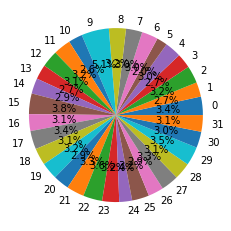

In [ ]:
import matplotlib.pyplot as plt
labels = [x for x in range(32)]
num_labels = [sum(train.label == x) for  x in range(32)]
plt.pie(num_labels, labels=labels, autopct='%1.1f%%')
plt.show()

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset
from IPython.display import clear_output

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class EmotionDataset(Dataset):
    def __init__(self, mode, df, include_utterance, tokenizer):
        assert mode in ['train', 'valid', 'test']
        self.mode = mode
        self.df = df.fillna("")
        self.len = len(self.df)
        self.include_utterance = include_utterance
        self.tokenizer = tokenizer
    
    # 定義回傳一筆訓練 / 測試數據的函式
    def __getitem__(self, idx):
        if self.mode == 'test':
            if self.include_utterance:
                prompt, utterance = self.df.iloc[idx, 2:4].values
            else:
                prompt = self.df.iloc[idx, 2]
            label_tensor = None
        else:
            if self.include_utterance:
                prompt, utterance, label = self.df.iloc[idx, 2:].values
            else:
                prompt, label = self.df.iloc[idx, [2, 4]].values
            label_tensor = torch.tensor(label)
            
        # 建立第一個句子的 BERT tokens 並加入分隔符號 [SEP]
        prompt = prompt.replace("_comma_", ",")
        text = "[CLS]" + prompt + "[SEP]"
        if self.include_utterance:
            utterance = utterance.replace("_comma_", ",")
            text += utterance + "[SEP]"
        text = text.replace("_comma_", ",")

        word_pieces = self.tokenizer.tokenize(text)
        
        # 將整個 token 序列轉換成索引序列
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        # 將第一句包含 [SEP] 的 token 位置設為 0
        if self.include_utterance:
            segments_tensor = torch.tensor(
                [0] * (len(self.tokenizer.tokenize(prompt)) + 2)
                + [1] * (len(self.tokenizer.tokenize(utterance)) + 1),
                dtype=torch.long
            )
        else:
            segments_tensor = torch.tensor([0] * len(word_pieces), 
                                           dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# # Initialize Datasets for Transformation
# trainset = EmotionDataset('train', train, True, tokenizer=tokenizer)
# validset = EmotionDataset('valid', valid, True, tokenizer=tokenizer)

# print('trainset size:', trainset.__len__())
# print('validset size:', validset.__len__())

In [ ]:
include_utterance = True

# Initialize Datasets for Transformation
trainset = EmotionDataset('train', train, include_utterance, tokenizer=tokenizer)
validset = EmotionDataset('valid', valid, include_utterance, tokenizer=tokenizer)

# print('trainset size:', trainset.__len__())
# print('validset size:', validset.__len__())

# 選擇第一個樣本
sample_idx = 0

# 將原始文本拿出做比較
if (include_utterance):
    prompt, utterance, label = trainset.df.iloc[sample_idx, 2:].values
else:
    prompt, label = trainset.df.iloc[sample_idx, [2, 4]].values

# 利用剛剛建立的 Dataset 取出轉換後的 id tensors
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

# 將 tokens_tensor 還原成文本
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

# 渲染前後差異，毫無反應就是個 print。可以直接看輸出結果
print(f"""[Original Statement]
prompt:     {prompt}
utterance:  {utterance if include_utterance else '[INFO] Utterance not included in this method!'}
label:      {label}

tokens: {tokens}

--------------------

[Tensors]
tokens_tensor:
    {tokens_tensor}

segments_tensor:
    {segments_tensor}

label_tensor:
    {label_tensor}

--------------------

[Recovered Text]
{combined_text}
""")

[Original Statement]
prompt:     I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.
utterance:  I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people_comma_ we felt like the only people in the world.
label:      13

tokens: ['[CLS]', 'i', 'remember', 'going', 'to', 'the', 'fireworks', 'with', 'my', 'best', 'friend', '.', 'there', 'was', 'a', 'lot', 'of', 'people', ',', 'but', 'it', 'only', 'felt', 'like', 'us', 'in', 'the', 'world', '.', '[SEP]', 'i', 'remember', 'going', 'to', 'see', 'the', 'fireworks', 'with', 'my', 'best', 'friend', '.', 'it', 'was', 'the', 'first', 'time', 'we', 'ever', 'spent', 'time', 'alone', 'together', '.', 'although', 'there', 'was', 'a', 'lot', 'of', 'people', ',', 'we', 'felt', 'like', 'the', 'only', 'people', 'in', 'the', 'world', '.', '[SEP]']

--------------------

[Tensors]
tokens_te

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# create_mini_batch 的參數 `samples` 是一個 list，裡頭的每個 element 都是
# 剛剛定義的 `FakeNewsDataset` 回傳的一個樣本，每個樣本都包含 3 tensors：
# - tokens_tensor
# - segments_tensor
# - label_tensor
# 它會對前兩個 tensors 作 zero padding，並產生前面說明過的 masks_tensors
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    # 測試集有 labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    
    # 先製作一條長度和 token_tensors 一樣的 0 張量
    # 接著將不為 zero padding 的位置設為1
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


# 初始化一個每次回傳 BATCH_SIZE 個訓練樣本的 DataLoader
# 利用 `collate_fn` 將 list of samples 合併成一個 mini-batch 是關鍵
trainloader = DataLoader(trainset, batch_size=32, 
                         collate_fn=create_mini_batch)

validloader = DataLoader(validset, batch_size=64, 
                         collate_fn=create_mini_batch)

In [ ]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([32, 73]) 
tensor([[ 101, 1045, 3342,  ..., 2088, 1012,  102],
        [ 101, 1045, 3342,  ...,    0,    0,    0],
        [ 101, 1045, 3342,  ...,    0,    0,    0],
        ...,
        [ 101, 1045, 2572,  ...,    0,    0,    0],
        [ 101, 1045, 2320,  ...,    0,    0,    0],
        [ 101, 1045, 2320,  ...,    0,    0,    0]])
------------------------
segments_tensors.shape = torch.Size([32, 73])
tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------------------------
masks_tensors.shape    = torch.Size([32, 73])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
------------------------
label_ids.shape        

In [ ]:
from transformers import BertForSequenceClassification
from IPython.display import clear_output

PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 32

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

print("""
name             module
-----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:16} {}".format(name, module))


name             module
-----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout          Dropout(p=0.1, inplace=False)
classifier       Linear(in_features=768, out_features=32, bias=True)


In [ ]:
# model.config

In [ ]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for data in tqdm(dataloader):
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            
            if not compute_acc:
                # 只是單純要回傳預測值的話，不用計算準確度也不用紀錄 loss
                tokens_tensors, segments_tensors, masks_tensors = data[:3]
                outputs = model(input_ids=tokens_tensors, 
                                token_type_ids=segments_tensors, 
                                attention_mask=masks_tensors)
                logits = outputs[0]
                _, pred = torch.max(logits.data, 1)
            else:
                # 否則就要計算 loss，這邊有一個小細節是 model 如果有吃 label 的話，
                # output[0]會變成是 loss，沒有吃 label 時 output[0] 會是 logits
                tokens_tensors, segments_tensors, masks_tensors, labels = data[:4]
                outputs = model(input_ids=tokens_tensors, 
                                token_type_ids=segments_tensors, 
                                attention_mask=masks_tensors,
                                labels=labels)
                loss = outputs[0]
                logits = outputs[1]
                _, pred = torch.max(logits.data, 1)
                running_loss += loss.item()
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        loss = running_loss / total
        return predictions, acc, loss
    
    return predictions
    
# # 讓模型跑在 GPU 上並取得訓練集的分類準確率
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# # 這邊要記得確認 model 在 GPU 上運行 (投影片有說明)，否則會跑很久！
# print("device:", device)
# model = model.to(device)
# _, train_acc, train_loss = get_predictions(model, trainloader, compute_acc=True)
# print("train acc:", train_acc)
# print("train loss:", train_loss)

In [ ]:
%%time
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
EPOCHS = 3

for epoch in range(EPOCHS):
    running_loss = 0.0
    for data in tqdm(trainloader):
        
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        loss.backward()
        optimizer.step()

        # 紀錄當前 batch loss
        running_loss += loss.item()

    # 計算分類準確率
    _, train_acc, train_loss = get_predictions(model, trainloader, compute_acc=True)
    _, valid_acc, valid_loss = get_predictions(model, validloader, compute_acc=True)
    
    print('[epoch %d] train loss: %.3f, train acc: %.3f, valid loss: %.3f, valid acc: %.3f' %
          (epoch + 1, train_loss, train_acc, valid_loss, valid_acc))

device: cuda:0


  0%|          | 0/2631 [00:00<?, ?it/s]

  0%|          | 0/2631 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

[epoch 1] train loss: 0.040, train acc: 0.613, valid loss: 0.023, valid acc: 0.556


  0%|          | 0/2631 [00:00<?, ?it/s]

  0%|          | 0/2631 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

[epoch 2] train loss: 0.028, train acc: 0.711, valid loss: 0.022, valid acc: 0.574


  0%|          | 0/2631 [00:00<?, ?it/s]

  0%|          | 0/2631 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

[epoch 3] train loss: 0.021, train acc: 0.785, valid loss: 0.023, valid acc: 0.566
CPU times: user 1h 13min 47s, sys: 20min 59s, total: 1h 34min 46s
Wall time: 1h 34min 38s


In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')
print('Model saved!')

Model saved!


# Test

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=NUM_LABELS)
model.load_state_dict(torch.load("checkpoint.pth"))
model.to(device)
model.eval()
clear_output()

In [ ]:
testset = EmotionDataset("test", test, include_utterance, tokenizer=tokenizer)
testloader = DataLoader(testset, batch_size=256, 
                        collate_fn=create_mini_batch)

predictions = get_predictions(model, testloader)
predictions = predictions.cpu().numpy()

  0%|          | 0/43 [00:00<?, ?it/s]

In [ ]:
textfile = open('prediction.txt', 'w')
textfile.write(',pred' + '\n')
for Id, pred in enumerate(predictions):
    textfile.write('{},{}\n'.format(Id, pred))
textfile.close()

In [ ]:
my_submission = pd.DataFrame({'': test.index, 'pred': predictions})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

In [ ]:
from google.colab import files
files.download('checkpoint.pth')
files.download('prediction.txt')
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>